## keras_merge_3_app_predict
使用异常图片检测时top50-top100选出的，且没放入训练集的图片，验证模型的鲁棒性  
模型使用：Merge-tuning-2-v2.h5  
异常图片目录：data/anormal/diff,下面含cat和dog目录：  
- cat目录下有6张图片没放入训练集
- dog目录下全部没有放入训练集


In [19]:
'''
数据目录结构：
data/
    anormal/  #top50-top100选出的异常图片
        diff/  
           dog/  #9张图片
            dog.10161.jpg
            dog.10747.jpg
            ...
         cat/   #56张图片
            cat.10037.jpg
            cat.10270.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.utils import *
from sklearn.utils import shuffle

test_data_dir='data/anormal/diff'
#prep_data_process调用move_anormal_images函数得知下面列表
cat_list_file=['cat.7291.jpg','cat.7372.jpg','cat.6655.jpg','cat.10365.jpg','cat.7703.jpg','cat.12476.jpg']

#模型权重文件
model_h5file="Merge-tuning-2-v2.h5"  

In [2]:
#保存特征向量，这里只需要提取需要测试的图片的特征向量
def write_feature_data(MODEL, image_shape, weights_file, preprocess_input = None):
    input_tensor = Input((image_shape[0], image_shape[1], 3))
    x = input_tensor
    if preprocess_input:
        x = Lambda(preprocess_input)(x)
    
    base_model = MODEL(input_tensor=x, weights=weights_file, include_top=False, pooling = 'avg')

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(test_data_dir, image_shape, shuffle=False, 
                                             batch_size=8, class_mode=None) #因为图片很少，所以batch_size设成8
    print(test_generator.samples)

    test_feature = base_model.predict_generator(test_generator, test_generator.samples, verbose=1)
    
    with h5py.File("test_feature_%s.h5"%base_model.name) as h:
        h.create_dataset("test", data=test_feature)
        

In [3]:
#用三个模型fine-tuning时，预测结果最好的权重文件提取特征向量
write_feature_data(ResNet50, (224, 224), "no_top_ResNet50-fine-tuning-3-v1.h5",  preprocess_input = resnet50.preprocess_input)
print("get ResNet50 freature over!")
write_feature_data(Xception, (299, 299), "no_top_xception-fine-tuning-1.h5",  preprocess_input = xception.preprocess_input)
print("get Xception freature over!")
write_feature_data(InceptionResNetV2, (299, 299), "no_top_InceptonResNetV2-fine-tuning-2-v2.h5",  preprocess_input = inception_resnet_v2.preprocess_input)
print("get InceptionResNetV2 freature over!")

Found 65 images belonging to 2 classes.
65
65/65 [==============================] - 44s 676ms/step
get ResNet50 freature over!
Found 65 images belonging to 2 classes.
65
65/65 [==============================] - 13s 197ms/step
get Xception freature over!
Found 65 images belonging to 2 classes.
65
65/65 [==============================] - 23s 357ms/step
get InceptionResNetV2 freature over!


In [4]:
#从文件中读取特征向量和标签
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["test_feature_resnet50.h5", "test_feature_xception.h5", "test_feature_inception_resnet_v2.h5"]:
    with h5py.File(filename, 'r') as h:
        X_test.append(np.array(h['test']))
        
X_test = np.concatenate(X_test, axis=1)


In [6]:
#最优实验对应的模型
input_tensor = Input(X_test.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)
model2 = Model(input_tensor, x)

adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #训练快,把lr设置小一点
model2.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])

471/471 [==============================] - 0s 63us/step
Found 65 images belonging to 2 classes.
0 cat/cat.10037.jpg [0.04335557]


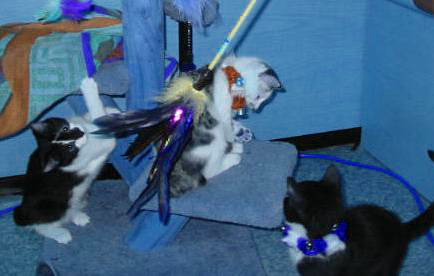

1 cat/cat.10270.jpg [0.07671114]


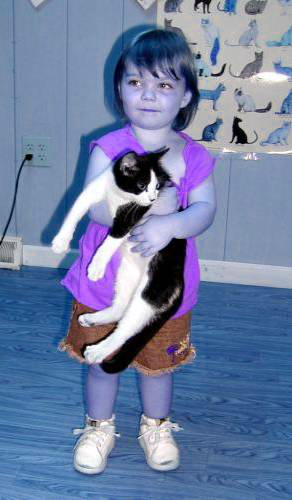

2 cat/cat.10365.jpg [0.01634838]


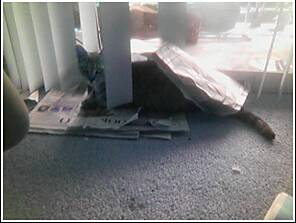

3 cat/cat.10636.jpg [0.00054101]


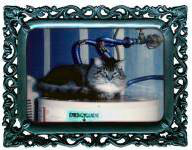

4 cat/cat.10946.jpg [0.08758748]


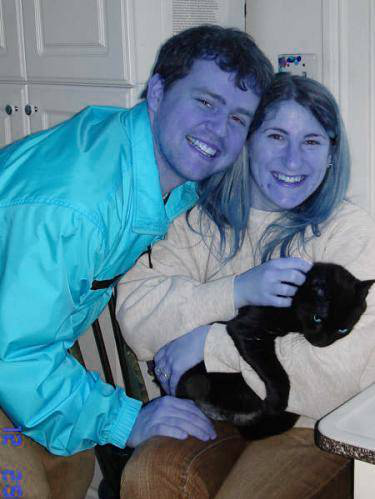

5 cat/cat.11222.jpg [0.33795664]


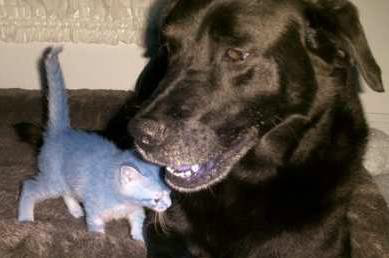

6 cat/cat.11231.jpg [0.12901343]


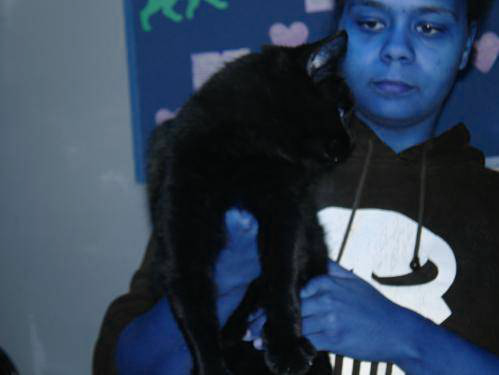

56 dog/dog.10161.jpg [0.59297985]


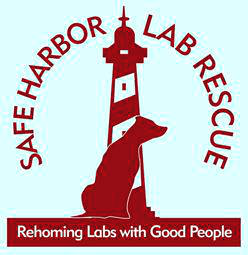

57 dog/dog.10747.jpg [0.5724329]


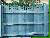

58 dog/dog.11266.jpg [0.9962495]


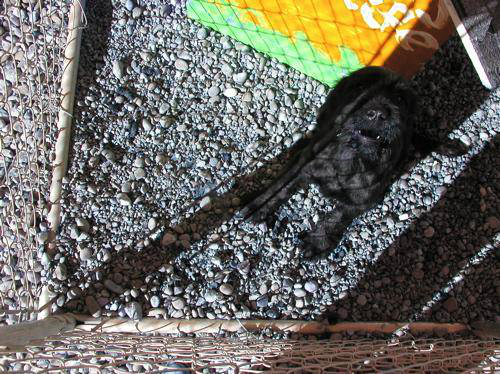

59 dog/dog.1259.jpg [0.4020212]


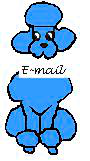

60 dog/dog.1773.jpg [0.910217]


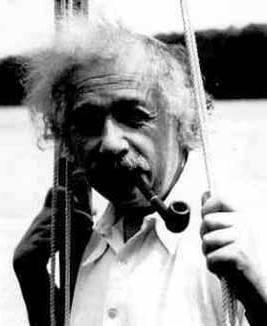

61 dog/dog.2422.jpg [0.9847311]


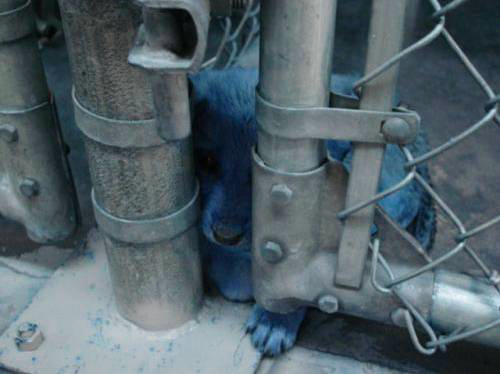

62 dog/dog.3889.jpg [0.9987318]


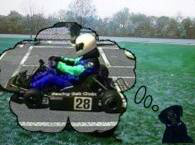

63 dog/dog.6475.jpg [0.85664845]


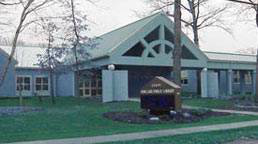

64 dog/dog.8898.jpg [0.5200885]


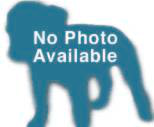

In [18]:
#预测


y_test = model2.predict(X_test, verbose=1)
    
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_data_dir, (224, 224), shuffle=False, 
                                         batch_size=8, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    
    if fname[:3] == 'cat' and i > 6:
        continue
    
    print(i, fname, y_test[i])
    fullname='data/anormal/diff/'+fname
    x = cv2.imread(fullname) 
    img = array_to_img(x)
    display(img)
